<a href="https://colab.research.google.com/github/fillipesansilva/Livraria/blob/master/Previs%C3%A3oSerieTemporal_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Previsão de Séries Temporais**
*Dataset utilizado:*
  * [Network traffic data in Trentino](https://www.nature.com/articles/sdata201555)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. Importar bibliotecas necessárias

In [ ]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Lendo dados

In [ ]:
# lendo csv e armazenando em um dataframe
dados = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/grid1.csv")
dados.timestamp = pd.to_datetime(dados.timestamp,format='%Y-%m-%d %H:%M:%S')
dados.head()

,timestamp,demand
0,2013-11-01 01:00:00,8.026270
1,2013-11-01 01:10:00,8.514179
2,2013-11-01 01:20:00,6.833425
3,2013-11-01 01:40:00,7.338716
4,2013-11-01 01:50:00,6.779705


## 3. Análise Preliminar dos Dados



In [ ]:
dados.shape

(8927, 2)

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

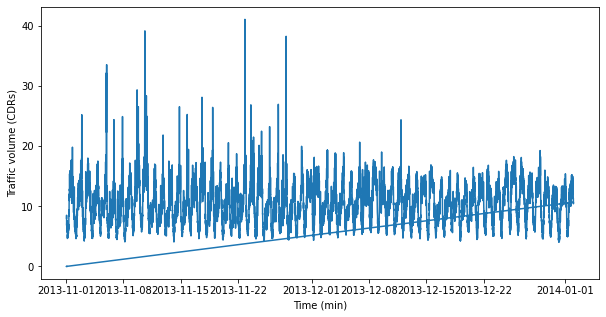

In [ ]:
#plotando série temporal
plt.plot(dados.timestamp,dados.demand)
plt.xlabel('Time (min)')
plt.ylabel('Traffic volume (CDRs)')
plt.show()


In [ ]:
## criar coluna com ano, mes, dia, hora e min.
dados['ano'] = dados.timestamp.dt.year
dados['mes'] = dados.timestamp.dt.month
dados['dia'] = dados.timestamp.dt.day
dados['hora'] = dados.timestamp.dt.hour
dados['min'] = dados.timestamp.dt.minute

dados.head(5)

,timestamp,demand,ano,mes,dia,hora,min
0,2013-11-01 01:00:00,8.026270,2013,11,1,1,0
1,2013-11-01 01:10:00,8.514179,2013,11,1,1,10
2,2013-11-01 01:20:00,6.833425,2013,11,1,1,20
3,2013-11-01 01:40:00,7.338716,2013,11,1,1,40
4,2013-11-01 01:50:00,6.779705,2013,11,1,1,50


In [ ]:
## agrupa dados de cada mes pelo ano
mensal = dados.groupby(['mes', 'dia'],as_index=True)['demand'].mean().reset_index().rename(columns={0:'demand'})
mensal.head()

,mes,dia,demand
0,1,1,10.642809
1,11,1,10.088774
2,11,2,10.525291
3,11,3,10.646864
4,11,4,9.755650


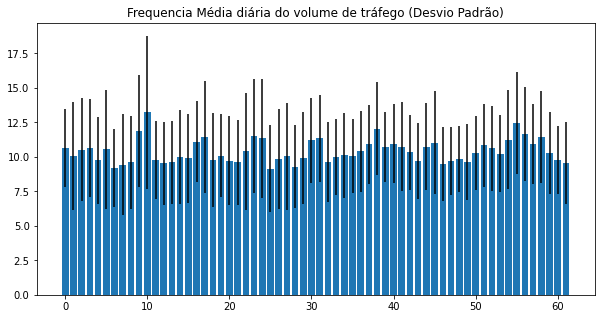

In [ ]:
# plotar vendas medias do produto por mes do ano
indice = [dia for dia in range(62)]
stats = dados.groupby(['mes', 'dia'],as_index=False)['demand'].agg(['mean','std'])
plt.bar(indice,stats['mean'],yerr=stats['std'])
plt.title('Frequencia Média diária do volume de tráfego (Desvio Padrão)')
plt.show()

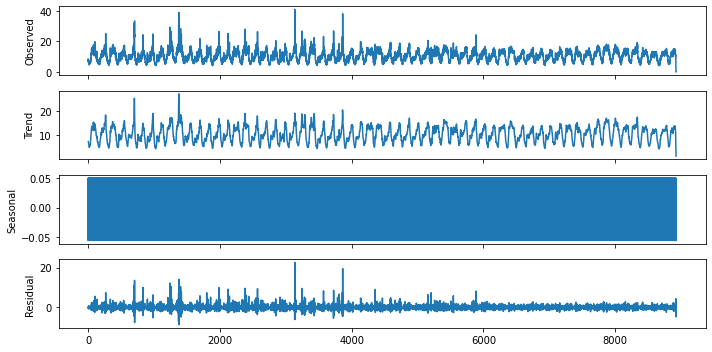

In [ ]:
#decomposicao da serie temporal em tendência, sazonalidade e ruído
decomposition = seasonal_decompose(dados.demand,model='additive',freq=7)
decomposition.plot()
plt.show()

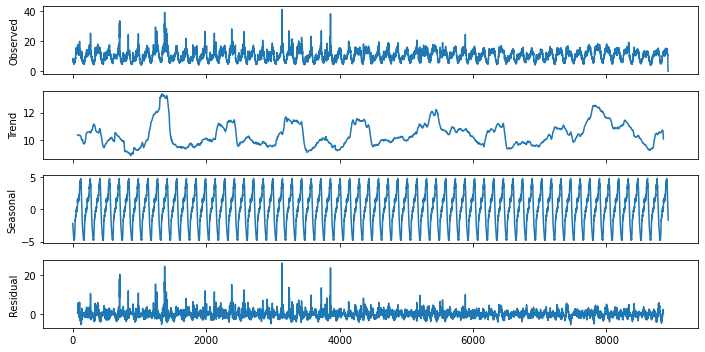

In [ ]:
#decomposicao da serie temporal
decomposition = seasonal_decompose(dados.demand,model='additive',freq=144)
decomposition.plot()
plt.show()

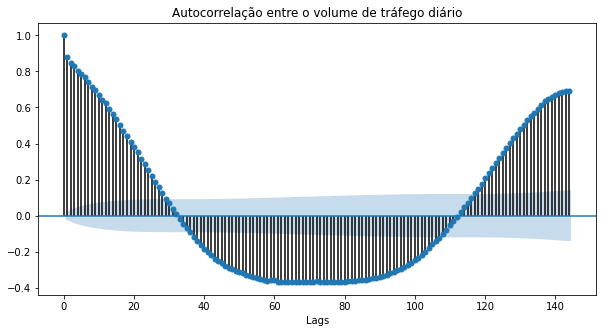

In [ ]:
# Função de autocorrelação entre as observações
plot_acf(dados.demand,lags=144)
plt.title('Autocorrelação entre o volume de tráfego diário')
plt.xlabel('Lags')
plt.show()

## 4. Organização dos dados para modelagem

In [ ]:
def organizarDados(sequence,n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
X,y = organizarDados(dados.demand,136)

In [ ]:
X[:10]

array([[ 8.02626975,  8.51417858,  6.8334249 , ...,  9.06334542,
         9.27248236,  7.95751916],
       [ 8.51417858,  6.8334249 ,  7.33871601, ...,  9.27248236,
         7.95751916, 13.22809941],
       [ 6.8334249 ,  7.33871601,  6.77970473, ...,  7.95751916,
        13.22809941,  7.83784993],
       ...,
       [ 6.16953368,  7.60545219,  6.5968658 , ...,  7.96408167,
         6.50032393,  7.76014743],
       [ 7.60545219,  6.5968658 ,  6.13982164, ...,  6.50032393,
         7.76014743,  7.89458017],
       [ 6.5968658 ,  6.13982164,  6.02758393, ...,  7.76014743,
         7.89458017,  6.23758987]])

In [ ]:
y[:10]

array([13.22809941,  7.83784993,  8.62155559,  7.82542426,  7.96408167,
        6.50032393,  7.76014743,  7.89458017,  6.23758987,  7.39430899])

In [ ]:
# dividindo dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

## 5. Treinando os modelos e fazendo previsão


In [ ]:
#definindo modelo de regressão linear
linear = LinearRegression()
linear.fit(X_train,y_train)
pred_linear = linear.predict(X_test)

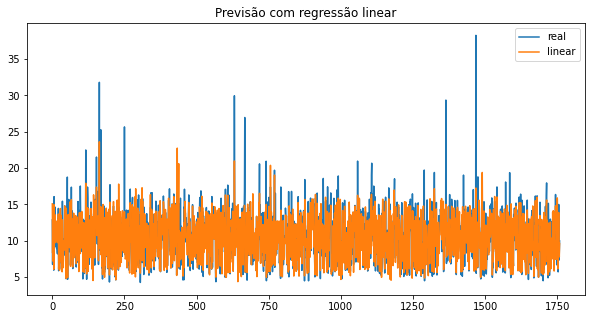

In [ ]:
#plotando resultados da MLP
plt.plot(y_test,label='real')
plt.plot(pred_linear,label='linear')
plt.legend()
plt.title('Previsão com regressão linear')
plt.show()

In [ ]:
#definindo modelo de árvore de decisão
arvore = DecisionTreeRegressor()
arvore.fit(X_train,y_train)
pred_arvore = arvore.predict(X_test)

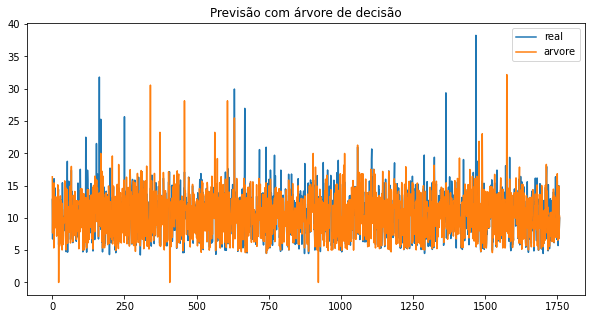

In [ ]:
#plotando resultados da árvore de decisão
plt.plot(y_test,label='real')
plt.plot(pred_arvore,label='arvore')
plt.legend()
plt.title('Previsão com árvore de decisão')
plt.show()

In [ ]:
#definindo modelo de random forest
floresta = RandomForestRegressor(n_estimators=100)
floresta.fit(X_train,y_train)
pred_floresta = floresta.predict(X_test)

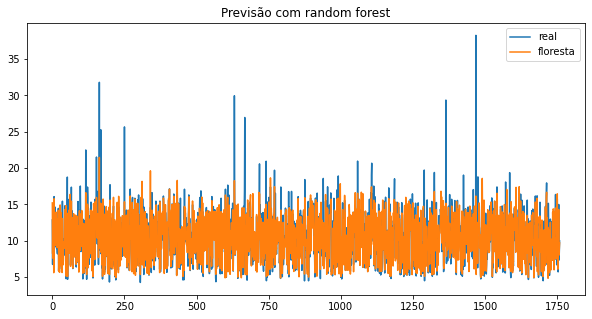

In [ ]:
#plotando resultados da random forest
plt.plot(y_test,label='real')
plt.plot(pred_floresta,label='floresta')
plt.legend()
plt.title('Previsão com random forest')
plt.show()

In [ ]:
#define modelo MLP
mlp = MLPRegressor(hidden_layer_sizes=(100),activation='logistic',max_iter=1000)
mlp.fit(X_train,y_train)
pred_mlp = mlp.predict(X_test)

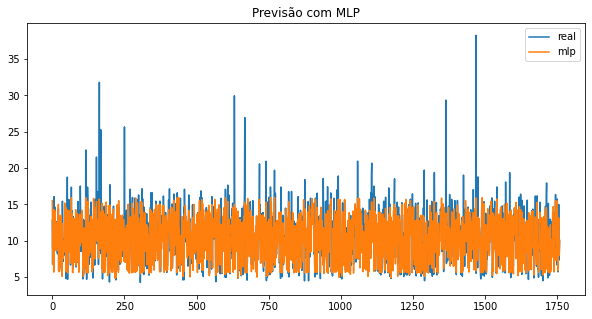

In [ ]:
#plotando resultados da MLP
plt.plot(y_test,label='real')
plt.plot(pred_mlp,label='mlp')
plt.legend()
plt.title('Previsão com MLP')
plt.show()

In [ ]:
print('MAE')
print('\tRegressão Linear:',round(mean_absolute_error(y_test,pred_linear),2))
print('\tArvore de Decisão:',round(mean_absolute_error(y_test,pred_arvore),2))
print('\tRandom Forest:',round(mean_absolute_error(y_test,pred_floresta),2))
print('\tMLP:',round(mean_absolute_error(y_test,pred_mlp),2))

MAE
	Regressão Linear: 0.93
	Arvore de Decisão: 1.34
	Random Forest: 0.92
	MLP: 1.08


In [ ]:
print('MSE')
print('\tRegressão Linear:',round(mean_squared_error(y_test,pred_linear),2))
print('\tArvore de Decisão:',round(mean_squared_error(y_test,pred_arvore),2))
print('\tRandom Forest:',round(mean_squared_error(y_test,pred_floresta),2))
print('\tMLP:',round(mean_squared_error(y_test,pred_mlp),2))

MSE
	Regressão Linear: 2.32
	Arvore de Decisão: 4.65
	Random Forest: 2.34
	MLP: 3.06


In [ ]:
print('RMSE')
print('\tRegressão Linear:',round(mean_squared_error(y_test,pred_linear)**(1/2),2))
print('\tArvore de Decisão:',round(mean_squared_error(y_test,pred_arvore)**(1/2),2))
print('\tRandom Forest:',round(mean_squared_error(y_test,pred_floresta)**(1/2),2))
print('\tMLP:',round(mean_squared_error(y_test,pred_mlp)**(1/2),2))

RMSE
	Regressão Linear: 1.52
	Arvore de Decisão: 2.16
	Random Forest: 1.53
	MLP: 1.75


In [ ]:
def mean_absolute_percentage_error(y_test,y_pred):
  y_test=y_test
  erro = 0
  for i in range(len(y_test)):
    erro += abs(y_test[i]-y_pred[i])/y_test[i]
  return erro/len(y_test)

In [ ]:
print('MAPE')
print('\tRegressão Linear:',round(mean_absolute_percentage_error(y_test,pred_linear)**(1/2),2))
print('\tArvore de Decisão:',round(mean_absolute_percentage_error(y_test,pred_arvore)**(1/2),2))
print('\tRandom Forest:',round(mean_absolute_percentage_error(y_test,pred_floresta)**(1/2),2))
print('\tMLP:',round(mean_absolute_percentage_error(y_test,pred_mlp)**(1/2),2))

MAPE
	Regressão Linear: 0.29
	Arvore de Decisão: 0.35
	Random Forest: 0.29
	MLP: 0.31


### **Avaliação**

A árvore de decisão mostrou-se eficiente ao predizer os valores de demanda.
